## MEWpy Example

A GECKO model simulation and optimization example.

We start by loading the GECKO model for yeast.
The model may be loaded using the original implementation over COBRApy. 

In [1]:
# Using geckopy package.
from geckopy.gecko import GeckoModel
model = GeckoModel('single-pool')

 The model may also be loaded using the MEWpy implementation
 We strongly suggest using the MEWpy implementation, based on REFRAMED, as it is considerably faster.

In [2]:
from mewpy.model.gecko import GeckoModel
model = GeckoModel('single-pool')

The Simulation class enables to easily perform simulations considering specific environmental conditions as well as other constraint, such protein knockouts or over/under expression. 
 

In [4]:
# Define environmental conditions (limit glucose consumption) 
envcond = {'r_1714_REV':(-10,1000)}

from mewpy.simulation import get_simulator
simul = get_simulator(model,envcond= envcond)

We start by running a Flux Balance Analysis phenotype prediction.

In [5]:
# FBA
result =simul.simulate()
print(result)

objective: 0.3254252917567038
Status: SStatus.OPTIMAL


Other phenotype simulation methods can explicitly be defined, such as parsimonious FBA.

In [6]:
from mewpy.simulation import  SimulationMethod
result= simul.simulate(method='pFBA')
print(result)

objective: 625.2854174098451
Status: SStatus.OPTIMAL


We aim to later optimize the production of L-tyrosine, whose exchange reaction has the 'r_1913' identifier.
As such it is important to analyse the flux variability. By default, MEWpy considers a 90% fraction of the objective when running a FVA.

In [8]:
# FVA of L-tyrosine
simul.FVA(reactions=['r_1913'])

{'r_1913': [0.0, 0.3297187936816093]}

We might also look at flux's values on the wild type, using the results from the previous pFBA. The biomass reaction has the identifier 'r_2111'.

In [9]:
# Flux values can be retreived from the simulation results object
reference = result.fluxes
# Biomass
print(reference['r_2111'])
# L-tyrosine
print(reference['r_1913'])

0.3250998017302527
0.0


In the wild type, and without adding any condition, the model does not produce L-tyronine.

GECKO models integrate proteomics into GSMMs. As such we may be interested on identifying essential proteins.

In [10]:
# Essential proteins
# Takes as argument the proteins prefix.
essential = simul.essential_proteins('draw_prot_')
essential[:10]

['draw_prot_Q12452',
 'draw_prot_P05150',
 'draw_prot_P80210',
 'draw_prot_P15180',
 'draw_prot_P32377',
 'draw_prot_P04161',
 'draw_prot_P39692',
 'draw_prot_P31116',
 'draw_prot_P40825',
 'draw_prot_P03962']

MEWpy allows to easely add contraints to phenotype simulations.

Let us consider a set of enzyme constraints obtained from a MEWpy optimization on the yeast GECKO model targeting the production of the same compound.

In [18]:
# Adding constraints to phenotype simulations
constraints ={'draw_prot_P32452':(0.0,4e-09),
              'draw_prot_P32178':(1.2e-06,10000),
              'draw_prot_P38715':0.0,
              'draw_prot_Q04430':0.0,
              'draw_prot_P21595':0.0
             }

We may now add these new constraints to a pFBA prediction, and analyse the L-tyrosine production and biomass.

In [19]:
result = simul.simulate(constraints=constraints,method='pFBA')
# Biomass
print(result.fluxes['r_2111'])
# L-tyrosine
print(result.fluxes['r_1913'])

0.16620098254926452
1.5105325049459961


We can observe that the simulation predicts that the introduce modifications will allow the organism to produce L-tyrosine.
Let us now perfom a flux balance analysis accounting with the modifications as well as plot the production envelope.

In [20]:
simul.FVA(reactions=['r_1913'],constraints=constraints)

{'r_1913': [1.5105113215577008, 1.7601437642590547]}

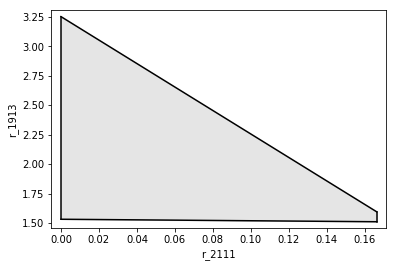

In [24]:
# Production envelope with constraints

from mewpy.visualization.envelope import plot_flux_envelope
plot_flux_envelope(simul,'r_2111','r_1913',constraints=constraints)

## GECKO model Optimization

We will now optimize the production of L-tyrosine by modifying the GECKO model enzymatic contraints, that is, by altering the availability of enzymes.

The optimization is performed by defining an Evolutionary Algorithm Optimization Problem.
To define a problem we start by identifiying the objective functions: biomass-product coupled yield and weighted yield.

In [13]:
from mewpy.optimization.evaluation import BPCY,WYIELD

evaluator_1 = BPCY("r_2111", "r_1913",method=SimulationMethod.lMOMA) 
evaluator_2 = WYIELD("r_2111", "r_1913")


We aim to find solutions that only include protein deletions or knock out, as such, we will instatiate a GeckoKOProblem, and consider a maximum of 6 deletions. 

In [14]:
# creates a new KO optimization problem
from mewpy.problems import GeckoKOProblem

# The problem takes as parameters the model, the objectives, optional environmental conditions,
# and the maximum number of simultaneous KOs. Other parameters can be passed such as, for example, 
# target or, alternatively, non target proteins. If not provided, targets are all non essential proteins. 

problem = GeckoKOProblem(model, 
                          fevaluation=[evaluator_1,evaluator_2], 
                          envcond = envcond,
                          candidate_max_size = 6)

We may now start the optimization process by instantiating an EA for the problem and set the running preferences.

Using 6 workers.
Running NSGAII


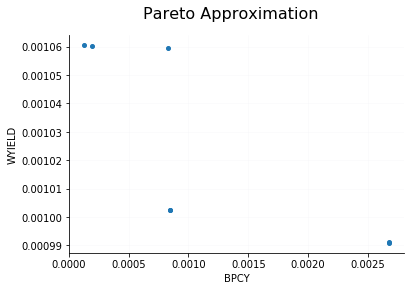

Gen    Eval|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
   0    100|  0.000000  0.002674  0.000000  0.000421  0.000860|  0.000000  0.001060  0.000990  0.000968  0.000140|
   1    200|  0.000000  0.019408  0.000131  0.001083  0.002132|  0.000000  0.019653  0.000990  0.001171  0.001860|
   2    300|  0.000000  0.023437  0.000844  0.001850  0.003508|  0.000988  0.019653  0.000993  0.001383  0.002610|
   3    400|  0.000000  0.023437  0.000868  0.002607  0.004811|  0.000988  0.019653  0.001004  0.001956  0.004059|
   4    500|  0.000000  0.050347  0.002648  0.004345  0.008525|  0.000988  0.028277  0.001060  0.003064  0.006197|
   5    600|  0.000000  0.050347  0.002792  0.008856  0.012391|  0.000988  0.028277  0.001060  0.006377  0.008742|
   6    700|  0.002707  0.050732  0.019292  0.018419  0.015233|  0.000988  0.028293  0.019599  0.014007  0.009583|
   7    800|  0.002673  0.067185  0.021435  0.032275  0.015115|  0.000992  0.093

In [15]:
from mewpy.optimization import EA

# A new instance of the EA optimizer for the problem with a stopping criteria of 10 iterations (1000 evaluations)
# mp: use parallel processing (by default half of the available threads).
# visualizer: display the pareto front of the evaluated population.

ea = EA(problem, max_generations = 10, mp =True, visualizer = True)

# runs the optimization
final_pop = ea.run()


The final population contains the best solutions found by the EA. We may choose to save the solutions, or run some analysis as previously seen.

In [42]:
final_pop[0]

[0.08151745148749975, 0.1141441390863936];{'P46969', 'P36013', 'P41939', 'P40506', 'P17505'}

In [43]:
final_pop[0].constraints

{'draw_prot_P46969': 0,
 'draw_prot_P36013': 0,
 'draw_prot_P41939': 0,
 'draw_prot_P40506': 0,
 'draw_prot_P17505': 0}